In [3]:
import pandas as pd
import re
import string
import nltk
import ssl
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [6]:
# !pip install openpyxl 해야함

file_path = 'C:/Users/USER/OneDrive - 금오공과대학교/02_연구실/02_김민준교수님/2_data\ROBLOX_DATA_PS.xlsx'

df = pd.read_excel(file_path, engine='openpyxl')

print(df.head())

                               reviewId             userName  \
0  8b33921b-b971-49ad-9c43-5f46535d8481       Rhylenn Taylor   
1  ddfa4628-ecd7-403d-b4f8-976655986017      Addalaide Clark   
2  8d9d55dd-df25-4329-af58-2178007c5434  jennavie kajornklin   
3  493e1a17-3af8-4e60-b5d2-a1f9f1056355              Josilyn   
4  4ac6c4f5-c019-46f0-b829-8e98d19a93ea                  Eli   

                                             content  score  thumbsUpCount  \
0  Perfect App! Though, There are a few problems ...      5            609   
1  I love this game. I have so much fun playing w...      4           1384   
2  Roblox is my favorite game. But when I play on...      4            576   
3  This game is great, amazing almost. But my sit...      1            166   
4  been glitching and completely freezing in the ...      1            143   

  reviewCreatedVersion                  at appVersion  
0            2.578.564 2023-06-24 03:07:01  2.578.564  
1            2.578.564 2023-06-25 

In [7]:
duplicates = df[df.duplicated(subset=['reviewId', 'at', 'content', 'score'], keep=False)]
print(f"중복된 행 수: {len(duplicates)}")

if not duplicates.empty:
    df = df.drop_duplicates(subset=['reviewId', 'at', 'content', 'score'], keep='first')
    print("중복된 행을 제거했습니다.")
else:
    print("중복된 행이 없습니다.")

중복된 행 수: 0
중복된 행이 없습니다.


In [8]:
# NLTK 다운로드 설정
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

이모지 제거, 품사 태깅, 소문자, 마침표, 불용어, 표제어 추출 함수

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def get_wordnet_pos(tag):
    if tag.startswith('J'): # 형용사
        return 'a'
    elif tag.startswith('V'): 
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'): # 부사
        return 'r'
    else:
        return 'n'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = remove_emoji(text)
    text = text.translate(str.maketrans('', '', string.punctuation)) # 구두점 제거
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    return lemmatized

In [ ]:
# 토큰화, 토큰화 후 10 토큰 미만 문장 제거
df['tokens'] = df['content'].apply(preprocess_text)
df['token_count'] = df['tokens'].apply(len)
df_filtered = df[df['token_count'] >= 10].copy()

print(df_filtered.head())

                               reviewId             userName  \
0  8b33921b-b971-49ad-9c43-5f46535d8481       Rhylenn Taylor   
1  ddfa4628-ecd7-403d-b4f8-976655986017      Addalaide Clark   
2  8d9d55dd-df25-4329-af58-2178007c5434  jennavie kajornklin   
3  493e1a17-3af8-4e60-b5d2-a1f9f1056355              Josilyn   
4  4ac6c4f5-c019-46f0-b829-8e98d19a93ea                  Eli   

                                             content  score  thumbsUpCount  \
0  Perfect App! Though, There are a few problems ...      5            609   
1  I love this game. I have so much fun playing w...      4           1384   
2  Roblox is my favorite game. But when I play on...      4            576   
3  This game is great, amazing almost. But my sit...      1            166   
4  been glitching and completely freezing in the ...      1            143   

  reviewCreatedVersion                  at appVersion  \
0            2.578.564 2023-06-24 03:07:01  2.578.564   
1            2.578.564 2023-06-2

gensim 설치 안될때  
import sys  
print(sys.executable)

In [ ]:
# LDA
# conda에서 설치, conda install -c conda-forge gensim
import gensim
from gensim import corpora
from gensim.models import LdaModel

texts = df_filtered['tokens'].tolist() # 각 문장을 리스트 형태의 리스트로 추출
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts] # bag of word 형식으로 변환


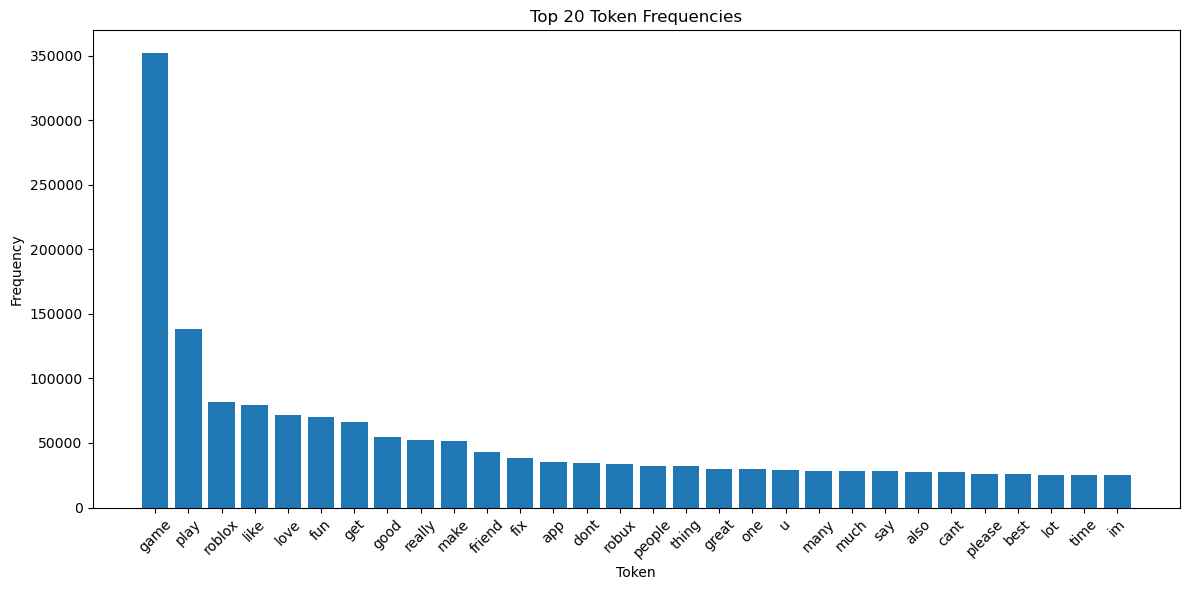

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# 모든 토큰을 하나의 리스트로 합치기
all_tokens = [token for tokens in df_filtered['tokens'] for token in tokens]

# 토큰 빈도수 계산
token_counts = Counter(all_tokens)

# 상위 30개 토큰 추출
most_common = token_counts.most_common(30)
words, counts = zip(*most_common)

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Token Frequencies")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [12]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=9,
                     passes=10,
                     random_state=42)

KeyboardInterrupt: 

In [ ]:
# 키워드 추출
topic_keywords = []
for i in range(9):
    words = lda_model.show_topic(i, topn=15)
    keywords = [word for word, _ in words]
    topic_keywords.append(keywords)

for idx, kw in enumerate(topic_keywords):
    print(f"Topic {idx+1} keywords:", kw)